In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision as tv

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tqdm

In [52]:
class Dataset2class(torch.utils.data.Dataset):
    def __init__(self, path1:str, path2:str):
        super().__init__()

        self.path1 = path1
        self.path2 = path2

        self.list1 = sorted(os.listdir(self.path1))
        self.list2 = sorted(os.listdir(self.path2))

    def __len__(self):
        return len(self.list1) + len(self.list2)

    def __getitem__(self, index):
        class_id = 0 if index % self.__len__() < len(self.list1) else 1
        index %= len(self.list1)

        img_name = (self.list2 if class_id else self.list1)[index]
        img_path = os.path.join(self.path2 if class_id else self.path1, img_name)

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return img, class_id

In [53]:
train_cats_path = 'datasets/cats/'
train_dogs_path = 'datasets/dogs/'

train_ds = Dataset2class(train_cats_path, train_dogs_path)

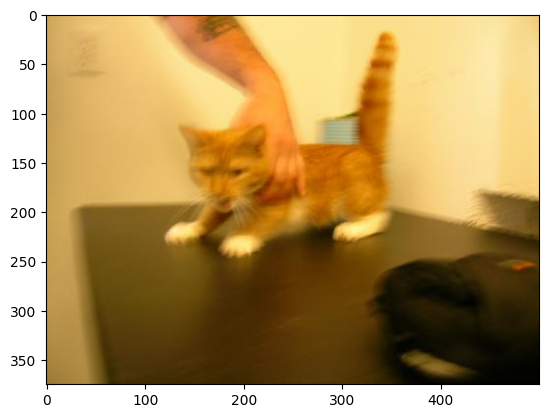

In [63]:
plt.imshow(train_ds[0][0])

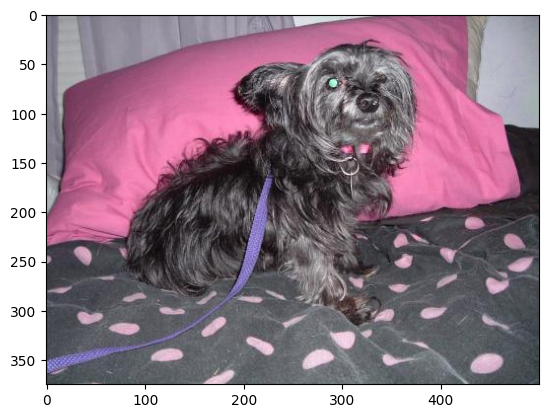

In [64]:
plt.imshow(train_ds[12500][0])